Exploration of UCI Breast Cancer Diagnostic Data
================================================

Looking at the breast cancer data and exploring the dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

In [20]:
cancer = load_breast_cancer()
print(cancer.keys())
cancer.target_names

dict_keys(['DESCR', 'feature_names', 'target_names', 'target', 'data'])


array(['malignant', 'benign'], 
      dtype='<U9')

In [15]:
print(cancer['feature_names'], len(cancer['feature_names']))

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'] 30


In [17]:
data = cancer.data
data

array([[  1.79900000e+01,   1.03800000e+01,   1.22800000e+02, ...,
          2.65400000e-01,   4.60100000e-01,   1.18900000e-01],
       [  2.05700000e+01,   1.77700000e+01,   1.32900000e+02, ...,
          1.86000000e-01,   2.75000000e-01,   8.90200000e-02],
       [  1.96900000e+01,   2.12500000e+01,   1.30000000e+02, ...,
          2.43000000e-01,   3.61300000e-01,   8.75800000e-02],
       ..., 
       [  1.66000000e+01,   2.80800000e+01,   1.08300000e+02, ...,
          1.41800000e-01,   2.21800000e-01,   7.82000000e-02],
       [  2.06000000e+01,   2.93300000e+01,   1.40100000e+02, ...,
          2.65000000e-01,   4.08700000e-01,   1.24000000e-01],
       [  7.76000000e+00,   2.45400000e+01,   4.79200000e+01, ...,
          0.00000000e+00,   2.87100000e-01,   7.03900000e-02]])

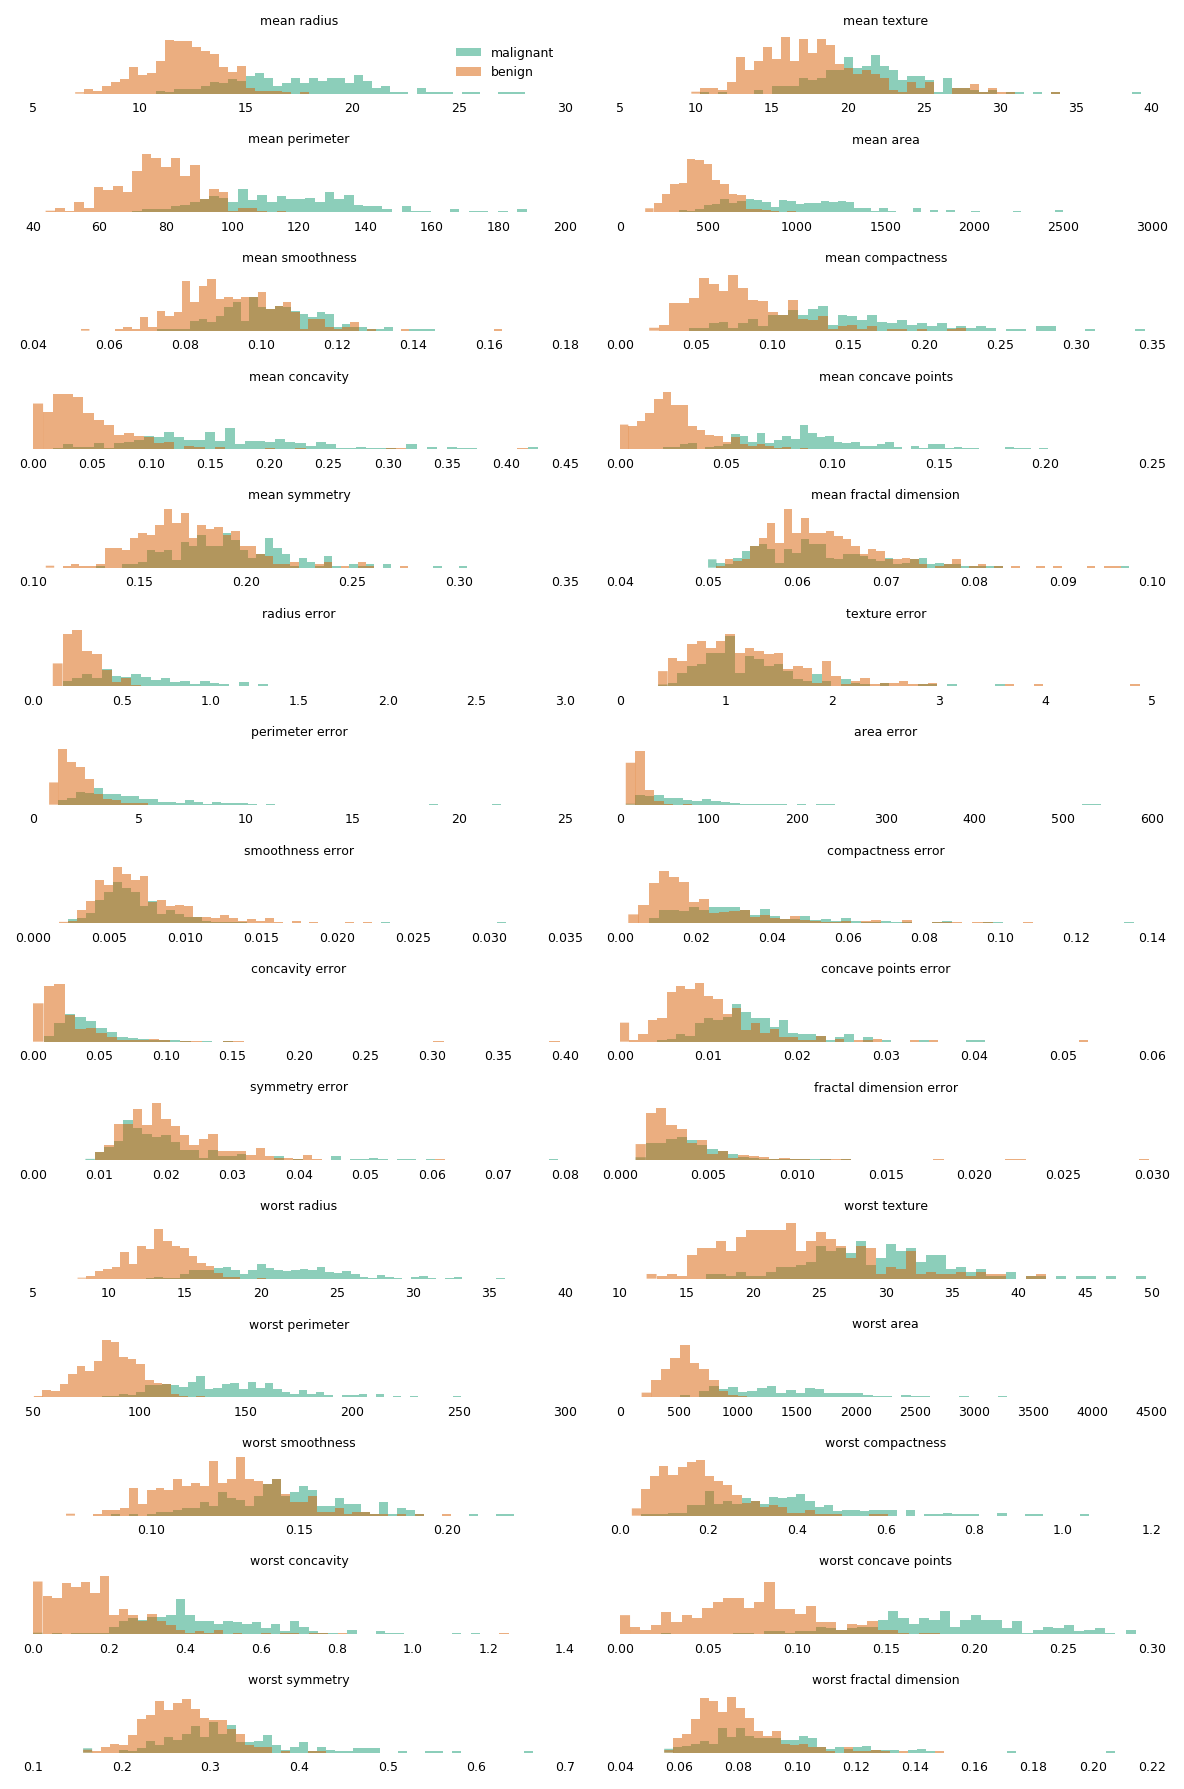

In [32]:
fig, axes = plt.subplots(nrows=15, ncols=2, figsize=(8, 12))
ax = axes.ravel()

malignant = data[cancer.target == 0]
benign = data[cancer.target == 1]

for i, (axis, name) in enumerate(zip(ax, cancer.feature_names)):
    _, bins = np.histogram(data[:, i], bins=50)
    axis.hist(malignant[:, i], bins=bins, alpha=0.5, linewidth=0)
    axis.hist(benign[:, i], bins=bins, alpha=0.5, linewidth=0)
    axis.set_title(name, fontdict={'fontsize': 6})
    for _, spine in axis.spines.items():
        spine.set_visible(False)
    axis.set_yticks(())
    axis.tick_params(bottom='off', top='off', left='off', right='off', labelsize=6)
fig.tight_layout()

ax[0].legend(['malignant', 'benign'], loc='best', fontsize=6, frameon=False)
plt.show()

Looking at the above, we can see a few features that we could use to discriminate between malignant and benign tumors. Any classification will probably use a combination of those features to classify the data.

Before we move on, we need to standardize our data so that the scalings don't skew the model, and split it to avoid our training data knowing about the test data.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data, cancer.target, random_state=20150808)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)